In [47]:
def r_geolocator(coordinates):
    # Convert Coordiantes to Address
    geolocator = Nominatim(user_agent="JE")
    location = geolocator.reverse(coordinates)
    #print(location.raw)
    #print(location.address)
    #print((location.latitude, location.longitude))
    return location.address

In [48]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import datetime
from geopy.geocoders import Nominatim

In [49]:
qlat,qlon = 42.8867166, -78.8783922
address = r_geolocator(f'{str(qlat)}, {str(qlon)}')


In [50]:
url   = f'https://forecast.weather.gov/MapClick.php?lat={qlat}&lon={qlon}&FcstType=digitalDWML'
page  = requests.get(url).text
soup  = BeautifulSoup(page,'xml')
dto   = soup.find_all("start-valid-time")
dte   = soup.find_all("end-valid-time"  )
Tlist = soup.find_all('temperature')
HPlist = soup.find_all('hourly-qpf')

In [51]:
### Configuring Time Element
data = [[],[]]
for i in range(len(dto)):
    data[0].append(datetime.datetime.strptime(str(dto[i]),"<start-valid-time>%Y-%m-%dT%H:%M:%S-04:00</start-valid-time>"))
    data[1].append(datetime.datetime.strptime(str(dte[i]),"<end-valid-time>%Y-%m-%dT%H:%M:%S-04:00</end-valid-time>"  ))

###   
for t in range(len(HPlist)):
    if   'hourly-qpf'  in str(HPlist[t]): HP=HPlist[t]
HP = str(HP).split("<value") # qpf

###
for t in range(len(Tlist)):
    if   'dew point'  in str(Tlist[t]): TD=Tlist[t]
    elif 'heat index' in str(Tlist[t]): HI=Tlist[t]
    elif 'hourly'     in str(Tlist[t]): T2=Tlist[t]
        
TD = str(TD).split("<value") # dew point
HI = str(HI).split("<value") # heat index
T2 = str(T2).split("<value") # temperautre


###
for i in range(len(TD)):
    TD[i] = TD[i].replace("</value>","").replace(">","").replace("</temperature","").strip().replace('xsi:nil="true"',str(np.nan))
    HI[i] = HI[i].replace("</value>","").replace(">","").replace("</temperature","").strip().replace('xsi:nil="true"',str(np.nan))
    T2[i] = T2[i].replace("</value>","").replace(">","").replace("</temperature","").strip().replace('xsi:nil="true"',str(np.nan))
    HP[i] = HP[i].replace("</value>","").replace(">","").replace("</hourly-qpf","").strip().replace('xsi:nil="true"',str(np.nan))

TD = TD[1:]
HI = HI[1:]
T2 = T2[1:]
HP = HP[1:]

###
for i in range(len(TD)):
    TD[i] = float(TD[i].replace("/",""))
    HI[i] = float(HI[i].replace("/",""))
    T2[i] = float(T2[i].replace("/",""))
    HP[i] = float(HP[i].replace("/",""))

### Printing Length of each list.
print(f'The length of the time elements = {              len(data[1])}')
print(f'The length of the dewpont elements = {                len(TD)}')
print(f'The length of the heat index elements = {             len(HI)}')
print(f'The length of the temperature elements = {            len(T2)}')
print(f'The length of the hourly precipitation elements = {   len(HP)}')

The length of the time elements = 168
The length of the dewpont elements = 168
The length of the heat index elements = 168
The length of the temperature elements = 168
The length of the hourly precipitation elements = 168


In [52]:
#---to dataframe
data = pd.DataFrame(data).T
data.columns = ["start-valid-time","end-valid-time"]
data['dew point' ] = TD
data['heat index'] = HI
data['temperature'    ] = T2
data['hourly-qpf'    ] = HP

In [53]:
data

,start-valid-time,end-valid-time,dew point,heat index,temperature,hourly-qpf
0,2023-09-28 13:00:00,2023-09-28 14:00:00,43.0,NaN,69.0,0.0
1,2023-09-28 14:00:00,2023-09-28 15:00:00,42.0,NaN,71.0,0.0
2,2023-09-28 15:00:00,2023-09-28 16:00:00,43.0,NaN,71.0,0.0
3,2023-09-28 16:00:00,2023-09-28 17:00:00,44.0,NaN,72.0,0.0
4,2023-09-28 17:00:00,2023-09-28 18:00:00,45.0,NaN,72.0,0.0
...,...,...,...,...,...,...
163,2023-10-05 08:00:00,2023-10-05 09:00:00,54.0,NaN,63.0,NaN
164,2023-10-05 09:00:00,2023-10-05 10:00:00,54.0,NaN,66.0,NaN
165,2023-10-05 10:00:00,2023-10-05 11:00:00,55.0,NaN,70.0,NaN
166,2023-10-05 11:00:00,2023-10-05 12:00:00,56.0,NaN,73.0,NaN


Text(0, 0.5, 'Precipitation')

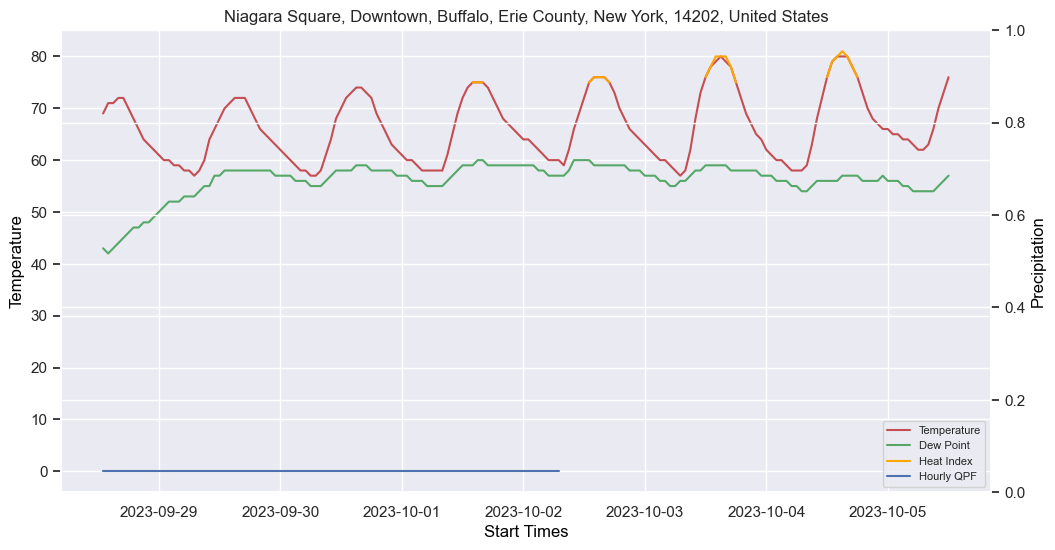

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title(address)
ax1.plot(data['start-valid-time'],data['temperature'],c = 'r',label = 'Temperature')
ax1.plot(data['start-valid-time'], data['dew point'], c= 'g', label = 'Dew Point')
ax1.plot(data['start-valid-time'], data['heat index'], c= 'orange', label = 'Heat Index')
ax1.plot(data['start-valid-time'], data['hourly-qpf'], c= 'b', label = 'Hourly QPF')
ax1.set_ylabel('Temperature', color='black')
ax1.set_xlabel('Start Times', color='black')
ax1.legend(loc = 'best', fontsize = '8')
#ax1.set_ylim(12,max(['temperature']))

ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation', color='black')  # we already handled the x-label with ax1